In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
%matplotlib inline

# Functions

In [3]:
from mll_calc.mll_pred import ratios, format_XY

In [4]:
def logpdf_calc(row, test_sample, unc):
    y_sim = row[test_sample>0].values.tolist()
    std = row.multiply(unc)[test_sample>0].values.tolist()
    y_mes = test_sample[test_sample>0].values.tolist()
    logpdf_list = stats.norm.logpdf(y_sim, loc=y_mes, scale=std)
    return logpdf_list

In [5]:
def loop_sfco(XY, test, pred, unc, lbls):
    logpdf_df = pd.DataFrame()
    for test_idx, row in test.iterrows():
        test_sample = row.drop(lbls)
        test_answer = row[lbls]
        
        pred_idx = pred['pred_idx'].loc[pred['sim_idx'] == test_idx]
        train_row = XY.loc[pred_idx.values[0]].drop(lbls)
        
        logpdf = logpdf_calc(train_row, test_sample, unc)
        logpdf = pd.Series(logpdf, index=train_row[test_sample>0].index, name=test_idx)
        
        if logpdf_df.empty:
            logpdf_df = pd.DataFrame(columns = test_sample.index.to_list())
        logpdf_df = logpdf_df.append(logpdf)
    return logpdf_df

In [6]:
unc = 0.05
lbls = ['ReactorType', 'CoolingTime', 'Enrichment', 'Burnup', 'OrigenReactor']
tamu_list = ['cs137/cs133', 'cs134/cs137', 'cs135/cs137', 'ba136/ba138',
             'sm150/sm149', 'sm152/sm149', 'eu154/eu153', 'pu240/pu239',
             'pu241/pu239', 'pu242/pu239']

# Data formatting & Calculations

In [7]:
pklfile = '../../sims_n_results/nucmoles_opusupdate_aug2019/not-scaled_15nuc.pkl'
XY = format_XY(pklfile)
XY = ratios(XY, tamu_list, lbls)

sfco_pkl = '~/sfcompo/format_clean/sfcompo_formatted.pkl'
sfco = pd.read_pickle(sfco_pkl)
sfco = ratios(sfco, tamu_list, lbls)

# for preds
sfco_path = '~/sims_n_results/nucmoles_opusupdate_aug2019/sfco/'
unc_job = 'Job0_unc0.05'
sfcoLL = pd.read_csv(sfco_path + unc_job + '/' + unc_job + '.csv')

## (a) Get test samples for iso-dependent logpdf calcs

manually found predictions with low and high errors, respectively

In [8]:
# ~6% burnup and enrichment errors + correct reactor pred
good_id = 'OHI-2|17G|C5|89G03' 
good_idx = 331
# > 200% burnup and enrichment error + wrong reactor pred
bad_id = 'NPD-1|1022|B|1' 
bad_idx = 268

In [10]:
grow = sfco.loc[sfco.index == good_id].squeeze()
grow_pred = sfcoLL.loc[sfcoLL.index == good_idx]
grow_train_idx = grow_pred['pred_idx']

In [11]:
brow = sfco.loc[sfco.index == bad_id].squeeze()
brow_pred = sfcoLL.loc[sfcoLL.index == bad_idx]
brow_train_idx = brow_pred['pred_idx']

In [12]:
print(grow_train_idx)
print(brow_train_idx)

331    8925
Name: pred_idx, dtype: int64
268    14605
Name: pred_idx, dtype: int64


## (b) logpdf calcs for "good" pred

In [13]:
test_sample = grow.drop(lbls)
test_answer = grow[lbls]
row = XY.loc[8925].drop(lbls)
logpdf = logpdf_calc(row, test_sample, unc)

In [14]:
logpdf

array([-19.14817197, -13.31293433,  -0.2413733 ,  -2.23560324])

In [15]:
np.sum(logpdf)

-34.93808284176995

In [16]:
#check match
sfcoLL['MaxLogLL'].loc[sfcoLL['sim_idx']==good_id]

331   -34.938083
Name: MaxLogLL, dtype: float64

In [17]:
row[test_sample>0]

cs134/cs137    0.0163462
pu240/pu239     0.368265
pu241/pu239     0.247569
pu242/pu239     0.166689
Name: 8925, dtype: object

In [18]:
logpdf = pd.Series(logpdf, index=row[test_sample>0].index, name='LogPDF')
logpdf

cs134/cs137   -19.148172
pu240/pu239   -13.312934
pu241/pu239    -0.241373
pu242/pu239    -2.235603
Name: LogPDF, dtype: float64

In [19]:
pd.DataFrame([row, test_sample, logpdf])

,cs137/cs133,cs134/cs137,cs135/cs137,ba136/ba138,sm150/sm149,sm152/sm149,eu154/eu153,pu240/pu239,pu241/pu239,pu242/pu239
8925,0.897989,0.016346,0.248352,0.010341,100.111607,41.344866,0.106392,0.368265,0.247569,0.166689
OHI-2|17G|C5|89G03,0.000000,0.022164,0.000000,0.000000,0.000000,0.000000,0.000000,0.473684,0.281307,0.137568
LogPDF,NaN,-19.148172,NaN,NaN,NaN,NaN,NaN,-13.312934,-0.241373,-2.235603


### Sidebar: Finding some samples to simulate

In [10]:
# print "good" pred labels
sfco.loc[sfco.index == good_id, lbls]

,ReactorType,CoolingTime,Enrichment,Burnup,OrigenReactor
OHI-2|17G|C5|89G03,pwr,0.0,1.6874,28717.0,Ohi-2_PWR


In [11]:
# print "bad" pred labels
sfco.loc[sfco.index == bad_id, lbls]

,ReactorType,CoolingTime,Enrichment,Burnup,OrigenReactor
NPD-1|1022|B|1,phwr,0.0,0.711,854.0,Nuclear Power Demonstration Reactor-1_CANDU


In [13]:
# print labels for a 9 ratio case
sfco.loc[sfco.index == 'VAN-2|EF05|WZR0058|E58-88', lbls]

,ReactorType,CoolingTime,Enrichment,Burnup,OrigenReactor
VAN-2|EF05|WZR0058|E58-88,pwr,0.0,4.5,43520.0,Vandellos-2_PWR


## (c) logpdf calcs for "bad" pred

In [20]:
test_sample = brow.drop(lbls)
test_answer = brow[lbls]
row = XY.loc[14605].drop(lbls)
logpdf = logpdf_calc(row, test_sample, unc)
logpdf = pd.Series(logpdf, index=row[test_sample>0].index, name='LogPDF')

In [21]:
np.sum(logpdf)

7.57858452439314

In [22]:
#check match
sfcoLL['MaxLogLL'].loc[sfcoLL['sim_idx']==bad_id]

268    7.578585
Name: MaxLogLL, dtype: float64

In [23]:
pd.DataFrame([row, test_sample, logpdf])

,cs137/cs133,cs134/cs137,cs135/cs137,ba136/ba138,sm150/sm149,sm152/sm149,eu154/eu153,pu240/pu239,pu241/pu239,pu242/pu239
14605,0.67858,0.000137,0.4421,0.002254,9.63477,4.754565,0.015806,0.065473,0.005232,0.000288
NPD-1|1022|B|1,0.00000,0.000000,0.0000,0.000000,0.00000,0.000000,0.000000,0.055976,0.004129,0.000314
LogPDF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.594151,-1.555835,8.540268


# Expand Calcs to Entire SFCOMPO DB

In [24]:
logpdf_df = loop_sfco(XY, sfco, sfcoLL, unc, lbls)

In [25]:
logpdf_df.sample(10)

,cs137/cs133,cs134/cs137,cs135/cs137,ba136/ba138,sm150/sm149,sm152/sm149,eu154/eu153,pu240/pu239,pu241/pu239,pu242/pu239
YNK-1|E6|C-A1|G-107,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.386169,3.532635,5.215175
TMI-1|NJ05YU|H6|B3J,NaN,NaN,NaN,NaN,-13.286297,-3.636586,NaN,0.704379,2.609359,3.071930
NOV-3|RP-3371A|58|4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.674064,4.510104,6.744375
GRM-1|B23|B3|K2680,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.613706,3.644666,5.094574
GAR-1|SA-13|E6|7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.349305,4.298478,7.036366
COO-1|CZ346|ADD2966|B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.199513,4.422056,5.702915
JPD-1|A-20|C3|KA-1040+660,NaN,-30.246236,NaN,NaN,NaN,NaN,NaN,3.673956,5.275301,7.443001
TVC-1|509-069|L11|7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.227234,3.789009,5.206139
NOV-4|213|25|8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.387765,4.021041,5.649760
MON-1|MTB099|H1|S5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-10.523500,2.845892,1.611120


## Stats on Pu Isotope Ratios

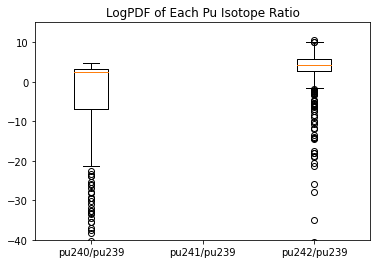

In [68]:
pu = [logpdf_df['pu240/pu239'],
      logpdf_df['pu241/pu239'],
      logpdf_df['pu242/pu239']]
fig, ax = plt.subplots()
ax.set_title('LogPDF of Each Pu Isotope Ratio')
ax.boxplot(pu, labels=['pu240/pu239', 'pu241/pu239', 'pu242/pu239'])
ax.set_ylim(-40, 15)
plt.show()

In [27]:
logpdf_df['pu240/pu239'].describe()

count    544.000000
mean      -6.514987
std       19.998108
min     -106.368642
25%       -6.891090
50%        2.562300
75%        3.261939
max        4.801567
Name: pu240/pu239, dtype: float64

In [28]:
logpdf_df['pu241/pu239'].describe()

count    543.000000
mean      -1.641779
std       20.742276
min     -128.179832
25%        1.571448
50%        3.370135
75%        3.820741
max        7.535007
Name: pu241/pu239, dtype: float64

In [29]:
logpdf_df['pu242/pu239'].describe()

count    544.000000
mean       2.436788
std        9.196064
min      -96.145311
25%        2.697182
50%        4.294617
75%        5.613382
max       10.632926
Name: pu242/pu239, dtype: float64

## Stats on Cs Isotope Ratios

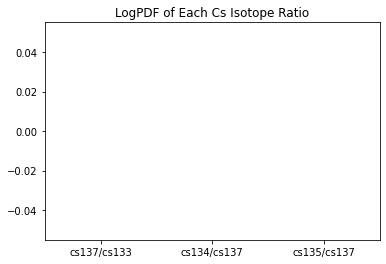

In [69]:
cs = [logpdf_df['cs137/cs133'],
      logpdf_df['cs134/cs137'],
      logpdf_df['cs135/cs137']]
fig, ax = plt.subplots()
ax.set_title('LogPDF of Each Cs Isotope Ratio')
ax.boxplot(cs, labels=['cs137/cs133', 'cs134/cs137', 'cs135/cs137'])
#ax.set_ylim(-40, 15)
plt.show()

In [70]:
logpdf_df['cs137/cs133'].describe()

count      45.000000
mean     -180.031390
std      1025.921941
min     -6789.207620
25%        -2.383887
50%         1.468763
75%         2.058430
max         2.365249
Name: cs137/cs133, dtype: float64

In [71]:
logpdf_df['cs134/cs137'].describe()

count    133.000000
mean      -6.879995
std       20.992119
min     -147.531583
25%      -12.617056
50%       -0.745675
75%        5.016665
max        8.388282
Name: cs134/cs137, dtype: float64

In [72]:
logpdf_df['cs135/cs137'].describe()

count     40.000000
mean     -27.931060
std       27.555771
min     -111.785441
25%      -41.708223
50%      -24.461021
75%       -4.510232
max        3.409395
Name: cs135/cs137, dtype: float64

## Stats on Sm/Eu Isotope Ratios

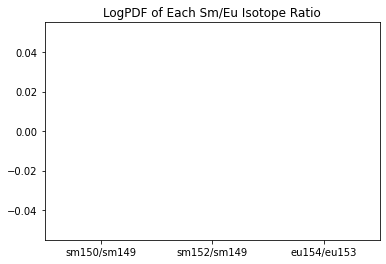

In [74]:
last3 = [logpdf_df['sm150/sm149'],
         logpdf_df['sm152/sm149'],
         logpdf_df['eu154/eu153']]
fig, ax = plt.subplots()
ax.set_title('LogPDF of Each Sm/Eu Isotope Ratio')
ax.boxplot(cs, labels=['sm150/sm149', 'sm152/sm149', 'eu154/eu153'])
plt.show()

In [75]:
logpdf_df['sm150/sm149'].describe()

count    105.000000
mean      -7.958776
std       10.296818
min      -70.498442
25%       -8.685561
50%       -4.832084
75%       -3.161528
max       -1.763939
Name: sm150/sm149, dtype: float64

In [76]:
logpdf_df['sm152/sm149'].describe()

count    105.000000
mean     -10.076113
std       12.685425
min      -86.321396
25%      -10.867071
50%       -5.882239
75%       -3.501622
max       -1.080357
Name: sm152/sm149, dtype: float64

In [77]:
logpdf_df['eu154/eu153'].describe()

count    45.000000
mean     -9.164255
std      12.323654
min     -44.838226
25%     -19.010468
50%      -5.105708
75%       0.373877
max       4.451885
Name: eu154/eu153, dtype: float64